### Inference

### 모델 로드

In [2]:
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "nvidia/segformer-b3-finetuned-cityscapes-1024-1024"
# we are going to do whole inference, so no resizing of the image
processor = SegformerImageProcessor(do_resize=False)
model = SegformerForSemanticSegmentation.from_pretrained(model_name)

# 모델의 헤드 클래스 수를 변경
model.config.num_labels = 13  # fine-tuning 데이터셋의 클래스 수에 맞게 변경
model.decode_head.classifier = torch.nn.Conv2d(768, model.config.num_labels, kernel_size=1)  # 768은 B3의 내부 차원 수
model.load_state_dict(torch.load("C:/Users/chldy/OneDrive/Documents/Deep_Learning_Bootcamp/image_project2/b3_10epoch_512288.pth", map_location=device))


# model.to(device)

<All keys matched successfully>

In [3]:
model.to(device)
model.eval()

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

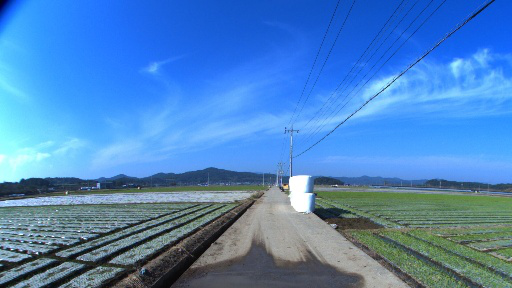

In [4]:
from PIL import Image

# load image + ground truth map
image_path = "C:/Users/chldy/OneDrive/바탕 화면/resized_valid_image/NIA_AgricultureAD_field_RGB_middle_Gyeongsangnamdo_2110250952_day_sunny_000002.jpg"
image = Image.open(image_path)

image
     

### 이미지 전처리

In [5]:
from PIL import Image
import torchvision.transforms as T
import torch

# 전처리 파이프라인 설정
def preprocess_image(image_path, transforms):
    # 이미지 파일을 열고 RGB로 변환
    image = Image.open(image_path).convert('RGB')

    # 전달된 전처리 변환을 이미지에 적용
    if transforms:
        image = transforms(image)
    
    return image

# 이미지 경로
image = Image.open(image_path)

# 전처리 변환 (훈련과 동일)
inference_transforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 이미지 전처리
processed_image = preprocess_image(image_path, inference_transforms)

# 차원 조정 (batch_size, C, H, W)
processed_image = processed_image.unsqueeze(0)  # 이는 모델에 입력하기 위해 필요한 배치 차원을 추가합니다.

processed_image.shape
processed_image= processed_image.to(device)




In [6]:
import torch

with torch.no_grad():
  outputs = model(processed_image)
  logits = outputs.logits

In [7]:
import torch.nn.functional as F
upsampled_logits = F.interpolate(logits, size=(288 ,512), mode="bilinear", align_corners=False)
# 소프트맥스를 적용하여 픽셀별 클래스 확률을 계산
probabilities = F.softmax(upsampled_logits, dim=1)

# 각 픽셀에서 최대 확률과 해당 인덱스를 계산
max_probs, predicted_classes = torch.max(probabilities, dim=1)

# 임계값 설정 (예: 0.5)
# threshold = 0.3

# 임계값 미만인 픽셀을 배경으로 설정
# predicted_classes[max_probs < threshold] = 0


# Tensor를 Numpy 배열로 변환
mask_np = predicted_classes.cpu().numpy()

### 시각화

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_segmentation(image, mask, alpha=1):
    """
    이미지와 세그멘테이션 마스크를 시각화합니다.
    :param image: PIL 이미지 또는 NumPy 배열
    :param mask: 세그멘테이션 마스크 (numpy 배열)
    :param alpha: 마스크의 투명도
    """
    if not isinstance(image, np.ndarray):
        image = np.array(image)
        
    mask = mask.squeeze()
    # 12개 클래스에 대한 색상 매핑 정의
    colors = np.array([
        [0, 0, 0],        # 배경
        [128, 64, 128],   # 클래스 1 - common_road
        [244, 35, 232],   # 클래스 2 - common_tree
        [70, 70, 70],     # 클래스 3 - field_corps
        [102, 102, 156],  # 클래스 4 - field_furrow
        [190, 153, 153],  # 클래스 5 - field_levee
        [153, 153, 153],  # 클래스 6 - orchard_road
        [250, 170, 30],   # 클래스 7 - orchard_tree
        [220, 220, 0],    # 클래스 8 - paddy_after_driving
        [107, 142, 35],   # 클래스 9 - paddy_before_driving
        [152, 251, 152],  # 클래스 10 - paddy_edge
        [70, 130, 180],   # 클래스 11 - paddy_rice
        [220, 20, 60]     # 클래스 12 - paddy_water
    ], dtype=np.uint8)

    colored_mask = colors[mask]
    combined = image.astype(np.float32) * (1 - alpha) + colored_mask.astype(np.float32) * alpha
    combined = combined.clip(0, 255).astype(np.uint8)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(combined)
    plt.title('Segmentation Overlay')
    plt.axis('off')

    plt.show()

# 이미지와 예측된 마스크 데이터를 이 함수에 전달하여 시각화
# image는 PIL 이미지, predicted_classes는 위 코드에서 계산된 예측 클래스 numpy 배열


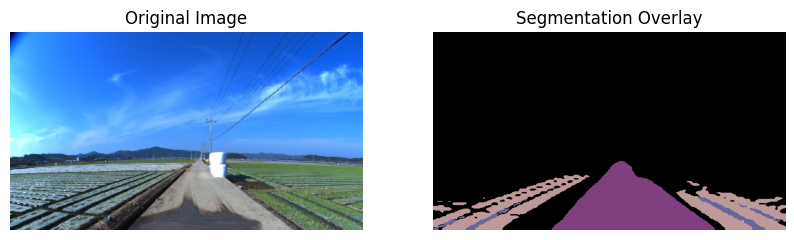

In [9]:
visualize_segmentation(image, mask_np)

### ground truth

In [11]:
import os
import json
from skimage.draw import polygon2mask
import matplotlib.pyplot as plt


id2label = {
            0: 'background',
            1: 'common_road',
            2: 'common_tree',
            3: 'field_corps',
            4: 'field_furrow',
            5: 'field_levee',
            6: 'orchard_road',
            7: 'orchard_tree',
            8: 'paddy_after_driving',
            9: 'paddy_before_driving',
            10: 'paddy_edge',
            11: 'paddy_rice',
            12: 'paddy_water'
        }

label2id = {v: k for k, v in id2label.items()}

image = Image.open(image_path).convert('RGB')
mask = np.full((image.height, image.width), 0, dtype=np.int32)  # 초기값을 0으로 설정
image_np=np.array(image)

base_path= "C:/Users/chldy/OneDrive/바탕 화면/resized_valid_annotations"
annotation_path= os.path.join(base_path, image_path.split('/')[-1].split('.')[0]+'.json')

with open(annotation_path, 'r') as f:
    img_info= json.load(f)

for obj in img_info['objects']:
    class_id = label2id.get(obj['label'])
    for pos in obj['position']:
        coords = [(y, x) for x, y in zip(pos[::2], pos[1::2])] #pos[::2]는 짝수 인덱스(모든 x 좌표), pos[1::2]는 홀수 인덱스(모든 y 좌표)
        # print(f"Coords for {obj['label']} with class ID {class_id}: {coords}")  # 디버깅용 좌표 출력

            # 좌표가 이미지 경계를 벗어나는지 확인
        out_of_bounds_coords = [(x, y) for y, x in coords if x < 0 or x >= image.width or y < 0 or y >= image.height]
        if out_of_bounds_coords:
            #print(f"Warning: Some coordinates for {obj['label']} are out of image bounds: {out_of_bounds_coords}")
            coords = [(max(0, min(image.height - 0.1, y)), max(0, min(image.width - 0.1, x))) for y, x in coords] # 이미지 벗어나는 좌표 클리핑

    

        poly_mask = polygon2mask((image.height, image.width), coords)

        # 디버깅용으로 poly_mask가 True인 위치 출력
        # true_indices = np.where(poly_mask)
        # true_positions = list(zip(true_indices[0], true_indices[1]))
        # print(f"True positions in poly_mask: {true_positions[:10]}")  # 처음 10개의 위치만 출력

        mask[poly_mask] = class_id

plt.figure(figsize=(12, 6))
        
plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title("Image")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("Mask")

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/chldy/OneDrive/바탕 화면/resized_valid_annotations\\NIA_AgricultureAD_field_RGB_middle_Gyeongsangnamdo_2110250952_day_sunny_000002.json'

### 실시간 이미지 inference 시간 

In [9]:
# 모델 로드는 이미 되어있다고 가정
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
import torch
from PIL import Image
import torchvision.transforms as T
import time
import torch.nn.functional as F
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "nvidia/segformer-b2-finetuned-cityscapes-1024-1024"
# we are going to do whole inference, so no resizing of the image
processor = SegformerImageProcessor(do_resize=False)
model = SegformerForSemanticSegmentation.from_pretrained(model_name)

# 모델의 헤드 클래스 수를 변경
model.config.num_labels = 13  # fine-tuning 데이터셋의 클래스 수에 맞게 변경
model.decode_head.classifier = torch.nn.Conv2d(768, model.config.num_labels, kernel_size=1)  # 768은 B3의 내부 차원 수
model.load_state_dict(torch.load("C:/Users/USER/Desktop/용용/딥러닝부트캠프/iamge_project2/10epoch_b3_512288.pth", map_location=device))


model.to(device)
model.eval()




# 전처리 파이프라인 정의
preprocess = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 실시간 inference 함수 정의
def real_time_inference(image, alpha=0.6):
    # 이미지 전처리 시작 시간
    start_time = time.time()
    
    if not isinstance(image, np.ndarray):
        image_np = np.array(image)
        
    # 이미지 전처리
    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0)  # 배치 차원 추가
    # 차원 조정 (batch_size, C, H, W)
    input_batch= input_batch.to(device)



    # 모델 추론
    with torch.no_grad():
        outputs = model(input_batch)
        logits = outputs.logits

    

    upsampled_logits = F.interpolate(logits, size=(288 ,512), mode="bilinear", align_corners=False)
    # 소프트맥스를 적용하여 픽셀별 클래스 확률을 계산
    probabilities = F.softmax(upsampled_logits, dim=1)

    # 각 픽셀에서 최대 확률과 해당 인덱스를 계산
    max_probs, predicted_classes = torch.max(probabilities, dim=1)

    # 임계값 설정 (예: 0.5)
    threshold = 0.5

    # 임계값 미만인 픽셀을 배경으로 설정
    predicted_classes[max_probs < threshold] = 0


    # Tensor를 Numpy 배열로 변환
    mask_np = predicted_classes.cpu().numpy()
    mask_np= mask_np.squeeze()

    # 추론 종료 시간
    end_time = time.time()

    # 지연 시간 계산
    latency = end_time - start_time
    print(f'Inference Latency: {latency:.4f} seconds')

    colors = np.array([
    [0, 0, 0],        # 배경
    [128, 64, 128],   # 클래스 1 - common_road
    [244, 35, 232],   # 클래스 2 - common_tree
    [70, 70, 70],     # 클래스 3 - field_corps
    [102, 102, 156],  # 클래스 4 - field_furrow
    [190, 153, 153],  # 클래스 5 - field_levee
    [153, 153, 153],  # 클래스 6 - orchard_road
    [250, 170, 30],   # 클래스 7 - orchard_tree
    [220, 220, 0],    # 클래스 8 - paddy_after_driving
    [107, 142, 35],   # 클래스 9 - paddy_before_driving
    [152, 251, 152],  # 클래스 10 - paddy_edge
    [70, 130, 180],   # 클래스 11 - paddy_rice
    [220, 20, 60]     # 클래스 12 - paddy_water
], dtype=np.uint8)
    
    colored_mask = colors[mask_np]
    combined = image_np.astype(np.float32) * (1 - alpha) + colored_mask.astype(np.float32) * alpha
    combined = combined.clip(0, 255).astype(np.uint8)
    

    return combined



In [ ]:
import time
import cv2
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as T
from transformers import SegformerForSemanticSegmentation

# 모델 로드
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "nvidia/segformer-b3-finetuned-cityscapes-1024-1024"
model = SegformerForSemanticSegmentation.from_pretrained(model_name)

model.config.num_labels = 13
model.decode_head.classifier = torch.nn.Conv2d(768, model.config.num_labels, kernel_size=1)
model.load_state_dict(torch.load("C:/Users/USER/Desktop/yong/deep_learning_bootcamp/image_project2/9epoch_b3_512288.pth", map_location=device))

model.to(device)
model.eval()

# 전처리 파이프라인
preprocess = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def apply_morphological_operations(mask):
    kernel = np.ones((5, 5), np.uint8)
    erosion = cv2.erode(mask, kernel, iterations=1)
    dilation = cv2.dilate(erosion, kernel, iterations=1)
    return dilation

def image2inf(image_paths, alpha=0.6):
    frames = []
    for image_path in image_paths:
        image = Image.open(image_path).convert("RGB")
        image_np = np.array(image)

        # 전처리 시간 측정 시작
        start_preprocess = time.time()

        # 이미지 전처리
        input_tensor = preprocess(image)
        input_batch = input_tensor.unsqueeze(0).to(device)

        # 전처리 시간 측정 종료
        end_preprocess = time.time()

        # 모델 추론 시간 측정 시작
        start_inference = time.time()

        # 모델 추론
        with torch.no_grad():
            outputs = model(input_batch)
            logits = outputs.logits

        # 모델 추론 시간 측정 종료
        end_inference = time.time()

        # 후처리 시간 측정 시작
        start_postprocess = time.time()

        upsampled_logits = torch.nn.functional.interpolate(logits, size=(image_np.shape[0], image_np.shape[1]), mode="bilinear", align_corners=False)
        probabilities = torch.nn.functional.softmax(upsampled_logits, dim=1).cpu().numpy()[0]
        predicted_classes = np.argmax(probabilities, axis=0)
        predicted_classes = apply_morphological_operations(predicted_classes.astype(np.uint8))

        colors = np.array([
            [0, 0, 0],
            [128, 64, 128],
            [244, 35, 232],
            [70, 70, 70],
            [102, 102, 156],
            [190, 153, 153],
            [153, 153, 153],
            [250, 170, 30],
            [220, 220, 0],
            [107, 142, 35],
            [152, 251, 152],
            [70, 130, 180],
            [220, 20, 60]
        ], dtype=np.uint8)

        colored_mask = colors[predicted_classes]
        combined = image_np.astype(np.float32) * (1 - alpha) + colored_mask.astype(np.float32) * alpha
        combined = combined.clip(0, 255).astype(np.uint8)

        frames.append(combined)

        # 후처리 시간 측정 종료
        end_postprocess = time.time()

        preprocess_time = end_preprocess - start_preprocess
        inference_time = end_inference - start_inference
        postprocess_time = end_postprocess - start_postprocess

        print(f"Preprocess Time: {preprocess_time:.4f} seconds")
        print(f"Inference Time: {inference_time:.4f} seconds")
        print(f"Postprocess Time: {postprocess_time:.4f} seconds")

    return frames

# 예시 이미지 경로 리스트
image_paths = ["path_to_image1.jpg", "path_to_image2.jpg"]

# 추론 수행
frames = image2inf(image_paths)


Inference Latency: 0.0365 seconds


Text(0.5, 1.0, 'Image')

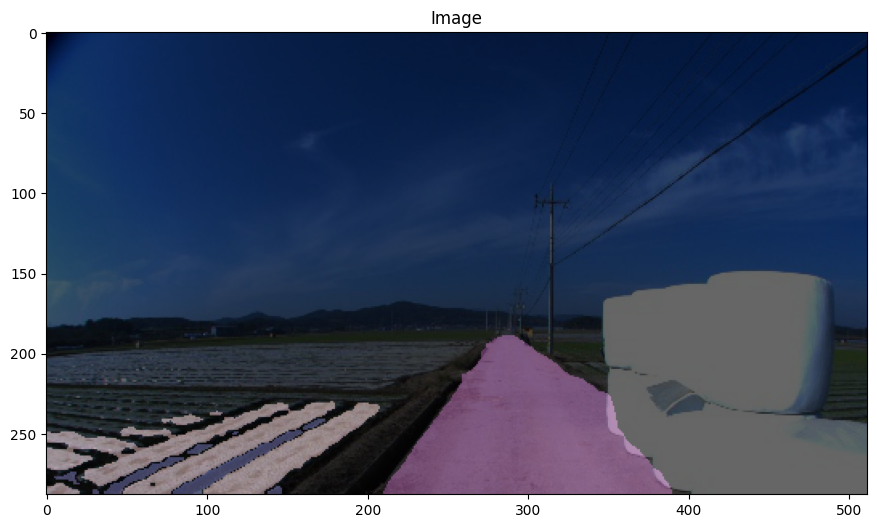

In [10]:
import matplotlib.pyplot as plt
# 예제 이미지 로드 및 실시간 inference 수행
image = Image.open("C:/Users/USER/Desktop/512x288/resized_valid_image/NIA_AgricultureAD_field_RGB_middle_Gyeongsangnamdo_2110250952_day_sunny_000036.jpg")
inference_image = real_time_inference(image)

plt.figure(figsize=(12, 6))
        
plt.subplot(1, 1, 1)
plt.imshow(inference_image)
plt.title("Image")

### 테스트 데이터 셋 생성

In [43]:
import cv2
import numpy as np
import albumentations as A
from albumentations.core.transforms_interface import ImageOnlyTransform
import os

class RealisticRain(ImageOnlyTransform):
    def __init__(self, slant=2, drop_length=10, drop_width=1, drop_color=(200, 200, 200), blur_value=3, rain_type='drizzle', always_apply=False, p=0.5):
        super(RealisticRain, self).__init__(always_apply, p)
        self.slant = slant
        self.drop_length = drop_length
        self.drop_width = drop_width
        self.drop_color = drop_color
        self.blur_value = blur_value
        self.rain_type = rain_type

    def apply(self, image, **params):
        image = image.copy()
        rain_layer = np.zeros_like(image, dtype=np.uint8)
        
        if self.rain_type == 'drizzle':
            num_drops = 300
            drop_length = self.drop_length // 2
        elif self.rain_type == 'heavy':
            num_drops = 700
            drop_length = self.drop_length * 2
        else:
            num_drops = 500
            drop_length = self.drop_length

        for _ in range(num_drops):
            x = np.random.randint(0, image.shape[1])
            y = np.random.randint(0, image.shape[0])
            end_x = x + self.slant
            end_y = y + drop_length
            cv2.line(rain_layer, (x, y), (end_x, end_y), self.drop_color, self.drop_width)

        rain_layer = cv2.blur(rain_layer, (self.blur_value, self.blur_value))
        brightness_coefficient = np.random.uniform(0.7, 1.0)
        rain_layer = cv2.addWeighted(rain_layer, brightness_coefficient, rain_layer, 0, 0)
        
        image = cv2.addWeighted(image, 1, rain_layer, 0.5, 0)
        
        return image

# 데이터 로드 및 증강 적용
images = [cv2.imread("C:/Users/USER/Desktop/resized_sequence0042_image_orchard/NIA_AgricultureAD_orchard_RGB_top_Jeollabukdo_2112141429_day_sunny_000001.jpg")]

# 이미지가 제대로 로드되었는지 확인
if images[0] is None:
    raise ValueError("이미지를 로드하는 데 실패했습니다. 경로를 확인하세요.")

rain_transform = A.Compose([
    RealisticRain(slant=1, drop_length=23, drop_width=1, drop_color=(200, 200, 200), blur_value=2, rain_type='drizzle', p=1.0)
])
rainy_images = [rain_transform(image=image)['image'] for image in images]

# 결과 이미지 저장
output_dir ="C:/Users/USER/Desktop/example/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# for i, img in enumerate(rainy_images):
#     output_path = f"{output_dir}rainy_image_{i}.jpg"
#     if not cv2.imwrite(output_path, img):
#         raise ValueError(f"이미지를 저장하는 데 실패했습니다: {output_path}")
#     else:
#         print(f"이미지 저장 성공: {output_path}")

# 저조도 효과 추가
low_light_transform = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=(-0.3, -0.1), contrast_limit=(-0.2, 0.2), p=1.0)
])

low_light_images = [low_light_transform(image=image)['image'] for image in rainy_images]

# 결과 이미지 저장
for i, img in enumerate(low_light_images):
    output_path = f"{output_dir}low_light_image_{i}.jpg"
    if not cv2.imwrite(output_path, img):
        raise ValueError(f"이미지를 저장하는 데 실패했습니다: {output_path}")
    else:
        print(f"이미지 저장 성공: {output_path}")


이미지 저장 성공: C:/Users/USER/Desktop/example/rainy_image_0.jpg
이미지 저장 성공: C:/Users/USER/Desktop/example/low_light_image_0.jpg


In [45]:
import cv2
import numpy as np
import albumentations as A
from albumentations.core.transforms_interface import ImageOnlyTransform
import os

class RealisticRain(ImageOnlyTransform):
    def __init__(self, slant=2, drop_length=10, drop_width=1, drop_color=(200, 200, 200), blur_value=3, rain_type='drizzle', always_apply=False, p=0.5):
        super(RealisticRain, self).__init__(always_apply, p)
        self.slant = slant
        self.drop_length = drop_length
        self.drop_width = drop_width
        self.drop_color = drop_color
        self.blur_value = blur_value
        self.rain_type = rain_type

    def apply(self, image, **params):
        image = image.copy()
        rain_layer = np.zeros_like(image, dtype=np.uint8)
        
        if self.rain_type == 'drizzle':
            num_drops = 300
            drop_length = self.drop_length // 2
        elif self.rain_type == 'heavy':
            num_drops = 700
            drop_length = self.drop_length * 2
        else:
            num_drops = 500
            drop_length = self.drop_length

        for _ in range(num_drops):
            x = np.random.randint(0, image.shape[1])
            y = np.random.randint(0, image.shape[0])
            end_x = x + self.slant
            end_y = y + drop_length
            cv2.line(rain_layer, (x, y), (end_x, end_y), self.drop_color, self.drop_width)

        rain_layer = cv2.blur(rain_layer, (self.blur_value, self.blur_value))
        brightness_coefficient = np.random.uniform(0.7, 1.0)
        rain_layer = cv2.addWeighted(rain_layer, brightness_coefficient, rain_layer, 0, 0)
        
        image = cv2.addWeighted(image, 1, rain_layer, 0.5, 0)
        
        return image

# 데이터 로드 및 증강 적용
image_sequence_path = "C:/Users/USER/Desktop/resized_sequence0042_image_orchard"
image_files = sorted([f for f in os.listdir(image_sequence_path) if f.endswith('.jpg')])

images = [cv2.imread(os.path.join(image_sequence_path, f)) for f in image_files]

# 이미지가 제대로 로드되었는지 확인
if any(img is None for img in images):
    raise ValueError("이미지를 로드하는 데 실패했습니다. 경로를 확인하세요.")

rain_transform = A.Compose([
    RealisticRain(slant=1, drop_length=23, drop_width=1, drop_color=(200, 200, 200), blur_value=2, rain_type='drizzle', p=1.0)
])

# 비 효과 적용
rainy_images = [rain_transform(image=image)['image'] for image in images]

# 저조도 효과를 점진적으로 적용
low_light_images = []
brightness_limit_start = -0.1
brightness_limit_end = -0.3
step = (brightness_limit_end - brightness_limit_start) / len(rainy_images)

for i, image in enumerate(rainy_images):
    brightness_limit = brightness_limit_start + step * i
    low_light_transform = A.Compose([
        A.RandomBrightnessContrast(brightness_limit=(brightness_limit, brightness_limit), contrast_limit=(-0.2, 0.2), p=1.0)
    ])
    low_light_image = low_light_transform(image=image)['image']
    low_light_images.append(low_light_image)

# 결과 이미지 저장
output_dir = "C:/Users/USER/Desktop/example/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for i, img in enumerate(low_light_images):
    output_path = os.path.join(output_dir, f"low_light_image_{i:04d}.jpg")
    if not cv2.imwrite(output_path, img):
        raise ValueError(f"이미지를 저장하는 데 실패했습니다: {output_path}")
    else:
        print(f"이미지 저장 성공: {output_path}")


이미지 저장 성공: C:/Users/USER/Desktop/example/low_light_image_0000.jpg
이미지 저장 성공: C:/Users/USER/Desktop/example/low_light_image_0001.jpg
이미지 저장 성공: C:/Users/USER/Desktop/example/low_light_image_0002.jpg
이미지 저장 성공: C:/Users/USER/Desktop/example/low_light_image_0003.jpg
이미지 저장 성공: C:/Users/USER/Desktop/example/low_light_image_0004.jpg
이미지 저장 성공: C:/Users/USER/Desktop/example/low_light_image_0005.jpg
이미지 저장 성공: C:/Users/USER/Desktop/example/low_light_image_0006.jpg
이미지 저장 성공: C:/Users/USER/Desktop/example/low_light_image_0007.jpg
이미지 저장 성공: C:/Users/USER/Desktop/example/low_light_image_0008.jpg
이미지 저장 성공: C:/Users/USER/Desktop/example/low_light_image_0009.jpg
이미지 저장 성공: C:/Users/USER/Desktop/example/low_light_image_0010.jpg
이미지 저장 성공: C:/Users/USER/Desktop/example/low_light_image_0011.jpg
이미지 저장 성공: C:/Users/USER/Desktop/example/low_light_image_0012.jpg
이미지 저장 성공: C:/Users/USER/Desktop/example/low_light_image_0013.jpg
이미지 저장 성공: C:/Users/USER/Desktop/example/low_light_image_0014.jpg
이미지 저장 성공:

### 이미지 동영상 변환

In [16]:
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
import torch
from PIL import Image
import torchvision.transforms as T
import time
import torch.nn.functional as F
import numpy as np
from pydensecrf.densecrf import DenseCRF2D
from pydensecrf.utils import unary_from_softmax, create_pairwise_bilateral, create_pairwise_gaussian

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "nvidia/segformer-b3-finetuned-cityscapes-1024-1024"
# we are going to do whole inference, so no resizing of the image
model = SegformerForSemanticSegmentation.from_pretrained(model_name)

# 모델의 헤드 클래스 수를 변경
model.config.num_labels = 13  # fine-tuning 데이터셋의 클래스 수에 맞게 변경
model.decode_head.classifier = torch.nn.Conv2d(768, model.config.num_labels, kernel_size=1)  # 768은 B3의 내부 차원 수
model.load_state_dict(torch.load("C:/Users/USER/Desktop/yong/deep_learning_bootcamp/image_project2/9epoch_b3_512288.pth", map_location=device))

model.to(device)
model.eval()


# 전처리 파이프라인 정의
preprocess = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])




def image2inf(image_paths, alpha=0.6):

    frames=[]
    for image_path in image_paths:
        image = Image.open(image_path).convert("RGB")

        if not isinstance(image, np.ndarray):
                image_np = np.array(image)
                
        # 이미지 전처리
        input_tensor = preprocess(image)
        input_batch = input_tensor.unsqueeze(0)  # 배치 차원 추가
        # 차원 조정 (batch_size, C, H, W)
        input_batch= input_batch.to(device)



        # 모델 추론
        with torch.no_grad():
            outputs = model(input_batch)
            logits = outputs.logits

        upsampled_logits = F.interpolate(logits, size=(288 ,512), mode="bilinear", align_corners=False)
            # 소프트맥스를 적용하여 픽셀별 클래스 확률을 계산
        probabilities = F.softmax(upsampled_logits, dim=1)

        # 각 픽셀에서 최대 확률과 해당 인덱스를 계산
        max_probs, predicted_classes = torch.max(probabilities, dim=1)

        

        # # 임계값 설정 (예: 0.5)
        # threshold = 0.8

        # # 임계값 미만인 픽셀을 배경으로 설정
        # predicted_classes[max_probs < threshold] = 0


        # Tensor를 Numpy 배열로 변환
        mask_np = predicted_classes.cpu().numpy()
        mask_np= mask_np.squeeze()


        colors = np.array([
        [0, 0, 0],        # 배경
        [128, 64, 128],   # 클래스 1 - common_road
        [244, 35, 232],   # 클래스 2 - common_tree
        [70, 70, 70],     # 클래스 3 - field_corps
        [102, 102, 156],  # 클래스 4 - field_furrow
        [190, 153, 153],  # 클래스 5 - field_levee
        [153, 153, 153],  # 클래스 6 - orchard_road
        [250, 170, 30],   # 클래스 7 - orchard_tree
        [220, 220, 0],    # 클래스 8 - paddy_after_driving
        [107, 142, 35],   # 클래스 9 - paddy_before_driving
        [152, 251, 152],  # 클래스 10 - paddy_edge
        [70, 130, 180],   # 클래스 11 - paddy_rice
        [220, 20, 60]     # 클래스 12 - paddy_water
        ], dtype=np.uint8)

        colored_mask = colors[mask_np]
        combined = image_np.astype(np.float32) * (1 - alpha) + colored_mask.astype(np.float32) * alpha
        combined = combined.clip(0, 255).astype(np.uint8)

        frames.append(combined)
    return frames

### crf 추가

In [5]:
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
import torch
from PIL import Image
import torchvision.transforms as T
import torch.nn.functional as F
import numpy as np
from pydensecrf.densecrf import DenseCRF2D
from pydensecrf.utils import unary_from_softmax, create_pairwise_bilateral, create_pairwise_gaussian

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "nvidia/segformer-b3-finetuned-cityscapes-1024-1024"
# we are going to do whole inference, so no resizing of the image
model = SegformerForSemanticSegmentation.from_pretrained(model_name)

# 모델의 헤드 클래스 수를 변경
model.config.num_labels = 13  # fine-tuning 데이터셋의 클래스 수에 맞게 변경
model.decode_head.classifier = torch.nn.Conv2d(768, model.config.num_labels, kernel_size=1)  # 768은 B3의 내부 차원 수
model.load_state_dict(torch.load("C:/Users/USER/Desktop/yong/deep_learning_bootcamp/image_project2/9epoch_b3_512288.pth", map_location=device))

model.to(device)
model.eval()

# 전처리 파이프라인 정의
preprocess = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def apply_crf(image, predicted_probabilities):
    h, w = image.shape[:2]
    n_labels = predicted_probabilities.shape[0]

    d = DenseCRF2D(w, h, n_labels)

    # 유니어리 에너지 설정
    unary = unary_from_softmax(predicted_probabilities)
    d.setUnaryEnergy(unary)

    # 쌍대 에너지 설정
    pairwise_gaussian = create_pairwise_gaussian(sdims=(3, 3), shape=image.shape[:2])
    d.addPairwiseEnergy(pairwise_gaussian, compat=3)

    pairwise_bilateral = create_pairwise_bilateral(sdims=(50, 50), schan=(20, 20, 20), img=image, chdim=2)
    d.addPairwiseEnergy(pairwise_bilateral, compat=10)

    # CRF 추론 수행
    Q = d.inference(5)
    result = np.argmax(Q, axis=0).reshape((h, w))

    return result

def image2inf(image_paths, alpha=0.6):
    frames = []
    for image_path in image_paths:
        image = Image.open(image_path).convert("RGB")

        if not isinstance(image, np.ndarray):
            image_np = np.array(image)

        # 이미지 전처리
        input_tensor = preprocess(image)
        input_batch = input_tensor.unsqueeze(0)  # 배치 차원 추가
        # 차원 조정 (batch_size, C, H, W)
        input_batch = input_batch.to(device)

        # 모델 추론
        with torch.no_grad():
            outputs = model(input_batch)
            logits = outputs.logits

        upsampled_logits = F.interpolate(logits, size=(image_np.shape[0], image_np.shape[1]), mode="bilinear", align_corners=False)
        # 소프트맥스를 적용하여 픽셀별 클래스 확률을 계산
        probabilities = F.softmax(upsampled_logits, dim=1).cpu().numpy()[0]

        # CRF 후처리 적용
        crf_result = apply_crf(image_np, probabilities)

        # Segmentation 결과를 색상으로 변환
        colors = np.array([
            [0, 0, 0],        # 배경
            [128, 64, 128],   # 클래스 1 - common_road
            [244, 35, 232],   # 클래스 2 - common_tree
            [70, 70, 70],     # 클래스 3 - field_corps
            [102, 102, 156],  # 클래스 4 - field_furrow
            [190, 153, 153],  # 클래스 5 - field_levee
            [153, 153, 153],  # 클래스 6 - orchard_road
            [250, 170, 30],   # 클래스 7 - orchard_tree
            [220, 220, 0],    # 클래스 8 - paddy_after_driving
            [107, 142, 35],   # 클래스 9 - paddy_before_driving
            [152, 251, 152],  # 클래스 10 - paddy_edge
            [70, 130, 180],   # 클래스 11 - paddy_rice
            [220, 20, 60]     # 클래스 12 - paddy_water
        ], dtype=np.uint8)

        colored_mask = colors[crf_result]
        combined = image_np.astype(np.float32) * (1 - alpha) + colored_mask.astype(np.float32) * alpha
        combined = combined.clip(0, 255).astype(np.uint8)

        frames.append(combined)
    return frames


### 형태학적 연산

In [7]:
import cv2
import numpy as np
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
import torch
from PIL import Image
import torchvision.transforms as T
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "nvidia/segformer-b3-finetuned-cityscapes-1024-1024"
model = SegformerForSemanticSegmentation.from_pretrained(model_name)

model.config.num_labels = 13  # fine-tuning 데이터셋의 클래스 수에 맞게 변경
model.decode_head.classifier = torch.nn.Conv2d(768, model.config.num_labels, kernel_size=1)  # 768은 B3의 내부 차원 수
model.load_state_dict(torch.load("C:/Users/USER/Desktop/yong/deep_learning_bootcamp/image_project2/9epoch_b3_512288.pth", map_location=device))

model.to(device)
model.eval()

preprocess = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def apply_morphological_operations(mask):
    kernel = np.ones((5, 5), np.uint8)
    erosion = cv2.erode(mask, kernel, iterations=1)
    dilation = cv2.dilate(erosion, kernel, iterations=1)
    return dilation

def image2inf(image_paths, alpha=0.6):
    frames = []
    for image_path in image_paths:
        image = Image.open(image_path).convert("RGB")

        if not isinstance(image, np.ndarray):
            image_np = np.array(image)

        input_tensor = preprocess(image)
        input_batch = input_tensor.unsqueeze(0)
        input_batch = input_batch.to(device)

        with torch.no_grad():
            outputs = model(input_batch)
            logits = outputs.logits

        upsampled_logits = F.interpolate(logits, size=(image_np.shape[0], image_np.shape[1]), mode="bilinear", align_corners=False)
        probabilities = F.softmax(upsampled_logits, dim=1).cpu().numpy()[0]

        predicted_classes = np.argmax(probabilities, axis=0)
        predicted_classes = apply_morphological_operations(predicted_classes.astype(np.uint8))

        colors = np.array([
            [0, 0, 0],        # 배경
            [128, 64, 128],   # 클래스 1 - common_road
            [244, 35, 232],   # 클래스 2 - common_tree
            [70, 70, 70],     # 클래스 3 - field_corps
            [102, 102, 156],  # 클래스 4 - field_furrow
            [190, 153, 153],  # 클래스 5 - field_levee
            [153, 153, 153],  # 클래스 6 - orchard_road
            [250, 170, 30],   # 클래스 7 - orchard_tree
            [220, 220, 0],    # 클래스 8 - paddy_after_driving
            [107, 142, 35],   # 클래스 9 - paddy_before_driving
            [152, 251, 152],  # 클래스 10 - paddy_edge
            [70, 130, 180],   # 클래스 11 - paddy_rice
            [220, 20, 60]     # 클래스 12 - paddy_water
        ], dtype=np.uint8)

        colored_mask = colors[predicted_classes]
        combined = image_np.astype(np.float32) * (1 - alpha) + colored_mask.astype(np.float32) * alpha
        combined = combined.clip(0, 255).astype(np.uint8)

        frames.append(combined)
    return frames


In [8]:
import os
base_path= "C:/Users/USER/Desktop/yong/deep_learning_bootcamp/image_project2/resized_img_4802"
image_names= os.listdir(base_path)

image_paths= []
for image in image_names:
    image_path= os.path.join(base_path, image)
    image_paths.append(image_path)

frames= image2inf(image_paths=image_paths)


def save_video(frames, output_path, fps=30):
    height, width = frames[0].shape[:2]
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 코덱 설정
    video = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for frame in frames:
        video.write(frame)

    video.release()

save_video(frames, 'C:/Users/USER/Desktop/yong/deep_learning_bootcamp/image_project2/example/segmented_video.mp4')


### 동영상 이미지로 변경

In [23]:
import cv2
import os

def video_to_frames(video_path, output_dir):
    # 동영상 파일 열기
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"동영상을 열 수 없습니다: {video_path}")
        return
    
    # 출력 디렉토리가 존재하지 않으면 생성
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_rate = int(cap.get(cv2.CAP_PROP_FPS))
    print(f"총 프레임 수: {frame_count}, 프레임 속도: {frame_rate} FPS")

    frame_idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # 프레임을 이미지로 저장
        output_path = os.path.join(output_dir, f"frame_{frame_idx:05d}.jpg")
        cv2.imwrite(output_path, frame)
        print(f"프레임 저장 성공: {output_path}")
        frame_idx += 1

    cap.release()
    print("모든 프레임이 저장되었습니다.")

# 사용 예시
video_path = "C:/Users/USER/Downloads/IMG_4812.MOV"  # 동영상 파일 경로
output_dir = "C:/Users/USER/Desktop/yong/deep_learning_bootcamp/image_project2/img_4812"  # 프레임 이미지가 저장될 디렉토리 경로

video_to_frames(video_path, output_dir)


총 프레임 수: 413, 프레임 속도: 23 FPS
프레임 저장 성공: C:/Users/USER/Desktop/yong/deep_learning_bootcamp/image_project2/img_4812\frame_00000.jpg
프레임 저장 성공: C:/Users/USER/Desktop/yong/deep_learning_bootcamp/image_project2/img_4812\frame_00001.jpg
프레임 저장 성공: C:/Users/USER/Desktop/yong/deep_learning_bootcamp/image_project2/img_4812\frame_00002.jpg
프레임 저장 성공: C:/Users/USER/Desktop/yong/deep_learning_bootcamp/image_project2/img_4812\frame_00003.jpg
프레임 저장 성공: C:/Users/USER/Desktop/yong/deep_learning_bootcamp/image_project2/img_4812\frame_00004.jpg
프레임 저장 성공: C:/Users/USER/Desktop/yong/deep_learning_bootcamp/image_project2/img_4812\frame_00005.jpg
프레임 저장 성공: C:/Users/USER/Desktop/yong/deep_learning_bootcamp/image_project2/img_4812\frame_00006.jpg
프레임 저장 성공: C:/Users/USER/Desktop/yong/deep_learning_bootcamp/image_project2/img_4812\frame_00007.jpg
프레임 저장 성공: C:/Users/USER/Desktop/yong/deep_learning_bootcamp/image_project2/img_4812\frame_00008.jpg
프레임 저장 성공: C:/Users/USER/Desktop/yong/deep_learning_bootcamp/i

### parameter 및 flops 

In [2]:
import torch
from torchinfo import summary
from transformers import SegformerForSemanticSegmentation
from fvcore.nn import FlopCountAnalysis, parameter_count_table

# Segformer 모델 초기화
model_name = "nvidia/segformer-b0-finetuned-ade-512-512"
model = SegformerForSemanticSegmentation.from_pretrained(model_name)

# 입력 사이즈 정의 (예: 1배치, 3채널, 512x512 이미지)
input_size = (3, 512, 512)

# 장치 설정 (GPU 사용 가능 시 GPU로 설정)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Parameter 수 계산
summary(model, input_size=(1, *input_size))

# FLOPs 계산
dummy_input = torch.randn(1, *input_size).to(device)
flops = FlopCountAnalysis(model, dummy_input)

print("FLOPs: ", flops.total())
print("Parameter count: ")
print(parameter_count_table(model))


Unsupported operator aten::div encountered 8 time(s)
Unsupported operator aten::softmax encountered 8 time(s)
Unsupported operator aten::add encountered 16 time(s)
Unsupported operator aten::gelu encountered 8 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by direct calls to .forward() or via other python methods. In the latter case they will have zeros for statistics, though their statistics will still contribute to their parent calling module.
segformer.encoder.block.0.1.drop_path, segformer.encoder.block.1.0.drop_path, segformer.encoder.block.1.1.drop_path, segformer.encoder.block.2.0.drop_path, segformer.encoder.block.2.1.drop_path, segformer.encoder.block.3.0.drop_path, segformer.encoder.block.3.1.drop_path


FLOPs:  8494448640
Parameter count: 
| name                                  | #elements or shape   |
|:--------------------------------------|:---------------------|
| model                                 | 3.8M                 |
|  segformer                            |  3.3M                |
|   segformer.encoder                   |   3.3M               |
|    segformer.encoder.patch_embeddings |    0.5M              |
|    segformer.encoder.block            |    2.8M              |
|    segformer.encoder.layer_norm       |    1.0K              |
|  decode_head                          |  0.4M                |
|   decode_head.linear_c                |   0.1M               |
|    decode_head.linear_c.0             |    8.4K              |
|    decode_head.linear_c.1             |    16.6K             |
|    decode_head.linear_c.2             |    41.2K             |
|    decode_head.linear_c.3             |    65.8K             |
|   decode_head.linear_fuse             |   0.3M     